In the notebook "[Cleaning the data for rapid prototyping](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai)" I showed how to create a small, fast, ready-to-use dataset for prototyping our models. The dataset created in that notebook, along with the metadata files it uses, are now [available here](https://www.kaggle.com/jhoward/rsna-hemorrhage-tif).

So let's use them to create a model! I'll come back and flesh this out some more early next week, but hopefully this is a useful starting point for now.

We'll be using the fastai.medical.imaging library here - for more information about this see the notebook [Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai). We'll also use the same basic setup that's in the notebook.

In [2]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *
from fastai2.vision.learner import _resnet_split
from fastai2.callback.tracker import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
set_num_threads(1)
set_seed(42)

path = Path('~/data/rsna').expanduser()
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

path_meta = path/'meta'
path_tif = path/'train_tif'

In [3]:
torch.cuda.set_device(3)

In [4]:
df_comb = pd.read_feather(path_meta/'comb.fth')
df_tst  = pd.read_feather(path_meta/'df_tst.fth').set_index('SOPInstanceUID')
df_samp = pd.read_feather(path_meta/'wgt_sample.fth').set_index('SOPInstanceUID')
bins = (path_meta/'bins.pkl').load()

## Prepare databunch

In [5]:
def tif_fn(fn): return path_tif/(os.path.splitext(os.path.basename(fn))[0]+'.tif')
fns = L(tif_fn(o) for o in df_samp.fname.values)
fn = fns[0]

In [6]:
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_samp.loc[Path(fn).with_suffix('').name][htypes].values.astype(np.float32)
fn2label(fn)

array([1., 0., 1., 1., 0., 0.], dtype=float32)

In [7]:
bs,nw = 128,8

tfms = [[PILCTScan.create], [fn2label,EncodedMultiCategorize(htypes)]]
split_idx = RandomSplitter()(fns)
dsrc = DataSource(fns, tfms, splits=split_idx)
nrm = Normalize(tensor([0.6]),tensor([0.25]))
aug = aug_transforms(p_lighting=0.)
batch_tfms = [IntToFloatTensor(div=2.**16), nrm, Cuda(), *aug]

In [8]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_item=[ToTensor],
                          after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

(tensor(0.1269), tensor(1.0345))

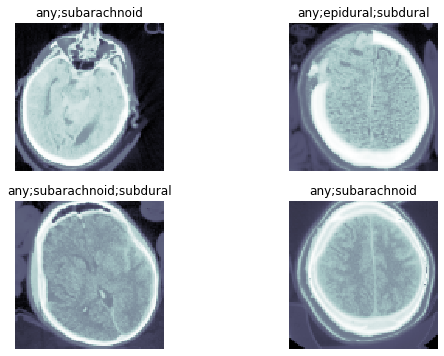

In [9]:
dbch = get_data(128, 96)
xb,yb = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4, figsize=(9,6))
xb.mean(),xb.std()

In [10]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [11]:
opt_acc_metric = optim_metric(accuracy_any, 'thresh', (0.,1.))

In [12]:
loss_weights = tensor(2.0, 1, 1, 1, 1, 1).cuda()
loss_func = BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
    is_2d=False, activation=torch.sigmoid)
opt_func = partial(Adam, wd=0.01, eps=1e-3)
metrics=[accuracy_multi,opt_acc_metric]

In [13]:
def get_learner(fp16=True):
    dbch = get_data(128,128)
    learn = cnn_learner(dbch, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=metrics)
    w = learn.model[0][0].weight
    w.data = w.mean(1,keepdim=True)
    if fp16: learn = learn.to_fp16()
    return learn

In [51]:
learn = get_learner()

In [14]:
# lrf = learn.lr_find()

## Pretrain on sample

In [36]:
# cbs = [ShortEpochCallback()]
cbs = []

In [37]:
def do_fit(bs,sz,epochs,lr):
    learn.dbunch = get_data(bs, sz)
    learn.opt.clear_state()
    learn.freeze()
    learn.fit_one_cycle(1, slice(lr), cbs=cbs)
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr), cbs=cbs)
    return learn

In [17]:
learn = do_fit(128, 96, 12, 2e-2)
learn.save('s1')

epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.445165,0.357539,0.848453,0.839688,02:04


epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.344223,0.313392,0.875154,0.867065,02:22
1,0.315766,0.334514,0.863739,0.855661,02:23
2,0.302950,0.294742,0.887938,0.882317,02:23
3,0.285833,0.275796,0.894345,0.888156,02:24
4,0.269585,0.268109,0.895518,0.890251,02:27
5,0.255364,0.244873,0.904615,0.904301,02:22
6,0.239272,0.232614,0.908932,0.908560,02:25
7,0.223384,0.231937,0.909905,0.908010,02:38
8,0.203814,0.217827,0.918899,0.914674,02:48
9,0.183894,0.207072,0.921533,0.914434,02:43


In [18]:
learn = do_fit(128, 160, 12, 1e-2)
learn.save('s2')

epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.249028,0.232362,0.910661,0.905675,02:42


epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.218608,0.219289,0.917903,0.914262,03:12
1,0.205897,0.231533,0.913129,0.903236,03:13
2,0.204975,0.222166,0.912877,0.913678,03:12
3,0.195531,0.233726,0.914113,0.905812,02:41
4,0.182972,0.216725,0.921722,0.915980,02:39
5,0.168750,0.229530,0.918264,0.910174,02:41
6,0.152913,0.214388,0.923525,0.915567,02:39
7,0.133328,0.187103,0.931042,0.925598,02:41
8,0.112402,0.189346,0.935702,0.927247,02:39
9,0.092557,0.192406,0.938422,0.932021,02:39


In [19]:
learn = do_fit(128, 256, 10, 3e-3)
learn.save('s3')

epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.211982,0.226089,0.915527,0.910552,03:48


epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.167030,0.202714,0.927321,0.919174,04:35
1,0.144225,0.197692,0.927773,0.919896,04:33
2,0.132503,0.199799,0.931174,0.924945,04:33
3,0.117457,0.205317,0.931941,0.923640,04:32
4,0.102640,0.200023,0.934002,0.925804,04:33
5,0.085684,0.217411,0.935622,0.928243,05:05
6,0.069226,0.217503,0.938473,0.930613,04:34
7,0.054711,0.231254,0.939458,0.930956,04:36
8,0.044333,0.236650,0.940025,0.931403,04:32
9,0.040054,0.244799,0.939561,0.930991,04:35


In [20]:
learn = do_fit(128, 256, 10, 1e-3)
learn.save('s4')

epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.039315,0.252226,0.939853,0.931918,03:48


epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.039458,0.251359,0.939149,0.929995,04:45
1,0.044068,0.261483,0.937752,0.926869,04:43
2,0.047609,0.248502,0.937455,0.928792,04:35
3,0.045229,0.250038,0.939716,0.930235,04:35
4,0.040899,0.260451,0.938834,0.929273,04:34
5,0.035245,0.266347,0.939813,0.929926,04:33
6,0.029785,0.273814,0.940569,0.931712,04:36
7,0.025973,0.286196,0.941124,0.931094,04:36
8,0.022717,0.279227,0.940861,0.930819,04:33
9,0.021847,0.281769,0.941106,0.931059,04:36


## Scale up to full dataset

In [15]:
fns = df_comb.fname.values
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]
df_trn = df_comb[ df_comb.PatientID.isin(pat_trn)]
df_val = df_comb[~df_comb.PatientID.isin(pat_trn)]
df_comb.set_index('SOPInstanceUID', inplace=True)

In [16]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return TensorCTScan(x.hist_scaled(bins)[None])

def fn2label(fn): return df_comb.loc[Path(fn).with_suffix('').name][htypes].values.astype(np.float32)

In [17]:
tfms = [[dcm_tfm], [fn2label,EncodedMultiCategorize(htypes)]]
split_idx = [df_trn.index.values,df_val.index.values]
dsrc = DataSource(fns, tfms, splits=split_idx)
nrm = Normalize(tensor([0.6]),tensor([0.25]))
batch_tfms = [nrm, Cuda()]

In [18]:
assert not dsrc.overlapping_splits()

In [19]:
def get_data(bs, sz=None):
    bt = batch_tfms
    if sz is not None: bt = bt+[AffineCoordTfm(size=sz)]
    return dsrc.databunch(bs=bs, num_workers=nw, after_batch=bt)

In [20]:
dbch = get_data(128, 352)

In [21]:
x,y = to_cpu(dbch.one_batch())
x.shape

torch.Size([128, 1, 352, 352])

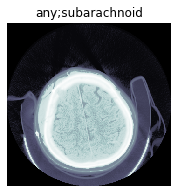

In [22]:
dbch.show_batch(max_n=1)

In [23]:
learn.dbunch = dbch
learn.opt.clear_state()

In [33]:
lr = 1e-3
learn.freeze()
learn.fit_one_cycle(1, slice(lr), cbs=ShortEpochCallback(pct=0.2))
learn.unfreeze()
learn.fit_one_cycle(1, slice(lr), cbs=cbs)

In [24]:
learn = get_learner(False)

In [26]:
learn.opt = None

In [27]:
learn.load('predone')

RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "0.4.0.conv3.weight", "0.4.0.bn3.weight", "0.4.0.bn3.bias", "0.4.0.bn3.running_mean", "0.4.0.bn3.running_var", "0.4.0.bn3.num_batches_tracked", "0.4.0.downsample.0.weight", "0.4.0.downsample.1.weight", "0.4.0.downsample.1.bias", "0.4.0.downsample.1.running_mean", "0.4.0.downsample.1.running_var", "0.4.0.downsample.1.num_batches_tracked", "0.4.1.conv3.weight", "0.4.1.bn3.weight", "0.4.1.bn3.bias", "0.4.1.bn3.running_mean", "0.4.1.bn3.running_var", "0.4.1.bn3.num_batches_tracked", "0.4.2.conv3.weight", "0.4.2.bn3.weight", "0.4.2.bn3.bias", "0.4.2.bn3.running_mean", "0.4.2.bn3.running_var", "0.4.2.bn3.num_batches_tracked", "0.5.0.conv3.weight", "0.5.0.bn3.weight", "0.5.0.bn3.bias", "0.5.0.bn3.running_mean", "0.5.0.bn3.running_var", "0.5.0.bn3.num_batches_tracked", "0.5.1.conv3.weight", "0.5.1.bn3.weight", "0.5.1.bn3.bias", "0.5.1.bn3.running_mean", "0.5.1.bn3.running_var", "0.5.1.bn3.num_batches_tracked", "0.5.2.conv3.weight", "0.5.2.bn3.weight", "0.5.2.bn3.bias", "0.5.2.bn3.running_mean", "0.5.2.bn3.running_var", "0.5.2.bn3.num_batches_tracked", "0.5.3.conv3.weight", "0.5.3.bn3.weight", "0.5.3.bn3.bias", "0.5.3.bn3.running_mean", "0.5.3.bn3.running_var", "0.5.3.bn3.num_batches_tracked", "0.6.0.conv3.weight", "0.6.0.bn3.weight", "0.6.0.bn3.bias", "0.6.0.bn3.running_mean", "0.6.0.bn3.running_var", "0.6.0.bn3.num_batches_tracked", "0.6.1.conv3.weight", "0.6.1.bn3.weight", "0.6.1.bn3.bias", "0.6.1.bn3.running_mean", "0.6.1.bn3.running_var", "0.6.1.bn3.num_batches_tracked", "0.6.2.conv3.weight", "0.6.2.bn3.weight", "0.6.2.bn3.bias", "0.6.2.bn3.running_mean", "0.6.2.bn3.running_var", "0.6.2.bn3.num_batches_tracked", "0.6.3.conv3.weight", "0.6.3.bn3.weight", "0.6.3.bn3.bias", "0.6.3.bn3.running_mean", "0.6.3.bn3.running_var", "0.6.3.bn3.num_batches_tracked", "0.6.4.conv3.weight", "0.6.4.bn3.weight", "0.6.4.bn3.bias", "0.6.4.bn3.running_mean", "0.6.4.bn3.running_var", "0.6.4.bn3.num_batches_tracked", "0.6.5.conv3.weight", "0.6.5.bn3.weight", "0.6.5.bn3.bias", "0.6.5.bn3.running_mean", "0.6.5.bn3.running_var", "0.6.5.bn3.num_batches_tracked", "0.7.0.conv3.weight", "0.7.0.bn3.weight", "0.7.0.bn3.bias", "0.7.0.bn3.running_mean", "0.7.0.bn3.running_var", "0.7.0.bn3.num_batches_tracked", "0.7.1.conv3.weight", "0.7.1.bn3.weight", "0.7.1.bn3.bias", "0.7.1.bn3.running_mean", "0.7.1.bn3.running_var", "0.7.1.bn3.num_batches_tracked", "0.7.2.conv3.weight", "0.7.2.bn3.weight", "0.7.2.bn3.bias", "0.7.2.bn3.running_mean", "0.7.2.bn3.running_var", "0.7.2.bn3.num_batches_tracked". 
	size mismatch for 0.4.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for 0.4.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for 0.4.2.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for 0.5.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for 0.5.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for 0.5.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 0.5.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 0.5.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 0.5.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for 0.5.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for 0.5.2.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for 0.5.3.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for 0.6.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for 0.6.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for 0.6.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 0.6.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 0.6.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 0.6.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for 0.6.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for 0.6.2.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for 0.6.3.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for 0.6.4.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for 0.6.5.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for 0.7.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for 0.7.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for 0.7.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.7.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.7.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.7.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 0.7.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for 0.7.2.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for 1.2.weight: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 1.2.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 1.2.running_mean: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 1.2.running_var: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for 1.4.weight: copying a param with shape torch.Size([512, 4096]) from checkpoint, the shape in current model is torch.Size([512, 1024]).

In [34]:
dbch = get_data(128, None)

In [35]:
learn.dbunch = dbch
learn.opt.clear_state()

In [36]:
learn.save('predone')

In [37]:
lr = 3e-4
learn.freeze()
learn.fit_one_cycle(1, slice(lr), cbs=ShortEpochCallback(pct=0.2))
learn.unfreeze()
learn.fit_one_cycle(1, slice(lr), cbs=cbs)

In [63]:
learn.load('predone', with_opt=False)

In [69]:
def get_data(bs, sz=None):
    bt = batch_tfms
    if sz is not None: bt = bt+[AffineCoordTfm(size=sz)]
    return dsrc.databunch(bs=bs, num_workers=nw, after_batch=bt)

In [70]:
dbch = get_data(128, None)

In [71]:
learn.dbunch = dbch
learn.opt.clear_state()

In [72]:
lr = 1e-3
learn.freeze()
learn.fit_one_cycle(1, slice(lr), cbs=ShortEpochCallback(pct=0.2))

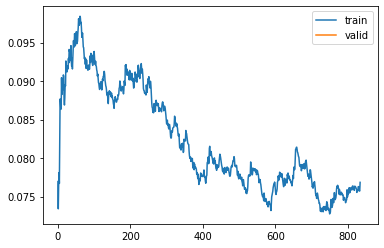

In [73]:
learn.recorder.plot_loss()

In [74]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(lr), cbs=cbs)

epoch,train_loss,valid_loss,accuracy_multi,opt_accuracy_any,time
0,0.060509,0.064550,0.978672,0.961421,57:32


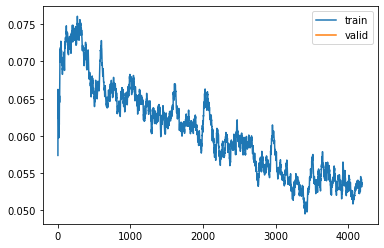

In [75]:
learn.recorder.plot_loss()

In [77]:
learn.save('done3')

## Prepare for submission

In [1]:
tst = test_dl(dbch, df_tst.fname.values)
x = tst.one_batch()[0]
x.min(),x.max()

NameError: name 'test_dl' is not defined

In [79]:
preds,targs = learn.get_preds(dl=tst)
preds_clipped = preds.clamp(.0001, .999)

In [80]:
ids = []
labels = []

for idx,pred in zip(df_tst.index, preds_clipped):
    for i,label in enumerate(htypes):
        ids.append(f"{idx}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [81]:
df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
df_csv.to_csv(f'submission.csv', index=False)
df_csv.head()

,ID,Label
0,ID_e3674b189_any,0.0001000000
1,ID_e3674b189_epidural,0.0001000000
2,ID_e3674b189_intraparenchymal,0.0001000000
3,ID_e3674b189_intraventricular,0.0001000000
4,ID_e3674b189_subarachnoid,0.0001000000


In [82]:
from IPython.display import FileLink, FileLinks
FileLink('submission.csv')

/home/jhoward/git/rsna_brain/submission.csv

In [ ]:
#export
def optim_metric(f, argname, bounds, tol=0.01, do_neg=True, get_x=False):
    "Replace metric `f` with a version that optimizes argument `argname`"
    def _f(preds, targs):
        def minfunc(x):
            kwargs = {argname:x}
            res = f(preds, targs, **kwargs)
            return -res if do_neg else res
        optres = scipy.optimize.minimize_scalar(minfunc, bounds=bounds, method='bounded',
                                                options={'xatol':0.01})
        fun = -optres.fun if do_neg else optres.fun
        return (fun,optres.x) if get_x else fun
    _f.__name__ = f'opt_{f.__name__}'
    return _f

In [53]:
t = to_cpu(learn.get_preds(with_input=True, with_loss=True, act=noop))
(inps,),preds,targs,losses = t

In [54]:
lw2 = tensor(2.0, 1, 1, 1, 1, 1)
lf2 = BaseLoss(nn.BCEWithLogitsLoss, pos_weight=lw2, floatify=True, flatten=False, 
    is_2d=False, activation=torch.sigmoid)

In [218]:
[lf2(preds*o/10, targs) for o in range(5,20)]

[tensor(0.4407),
 tensor(0.4173),
 tensor(0.4014),
 tensor(0.3913),
 tensor(0.3858),
 tensor(0.3839),
 tensor(0.3848),
 tensor(0.3880),
 tensor(0.3931),
 tensor(0.3998),
 tensor(0.4077),
 tensor(0.4168),
 tensor(0.4268),
 tensor(0.4376),
 tensor(0.4490)]